<a href="https://colab.research.google.com/github/shahriar1990/Transfer_Learning/blob/main/Image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   110M      0  0:00:07  0:00:07 --:--:--  111M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


In [5]:
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size =(180,180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory('PetImages',
                                                               validation_split=0.2,
                                                               subset='training',
                                                               seed =1337,
                                                               image_size=image_size,
                                                               batch_size=batch_size)



val_ds = tf.keras.preprocessing.image_dataset_from_directory('PetImages',
                                                             validation_split=0.2,
                                                             subset='validation',
                                                             seed=1337,
                                                             image_size=image_size,
                                                             batch_size = batch_size)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


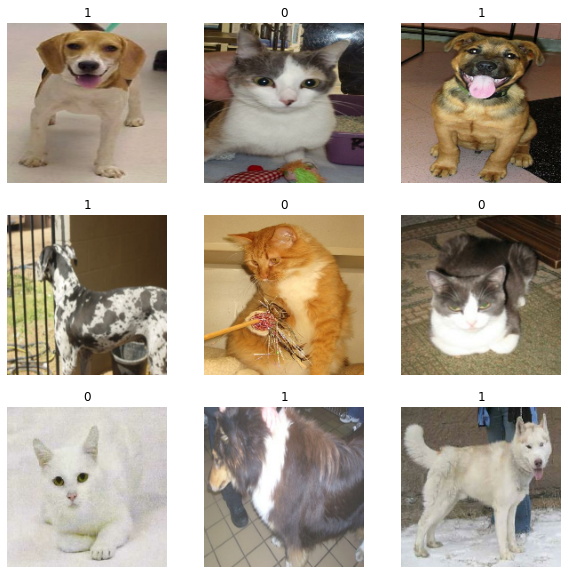

In [7]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(9):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

In [8]:
data_augmentation = keras.Sequential([layers.RandomFlip('horizontal'),
                                      layers.RandomRotation(0.1)])

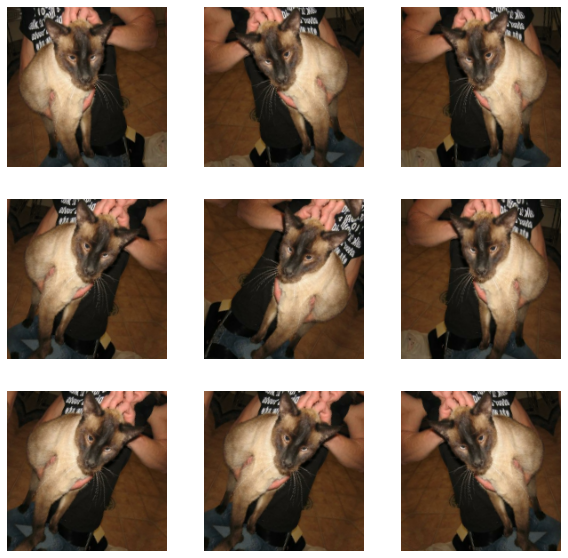

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
# inputs= keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# y = layers.Rescaling(1.0/255)(x)

In [11]:
augmented_train_ds = train_ds.map(lambda x , y:(data_augmentation(x,training=True),y))

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

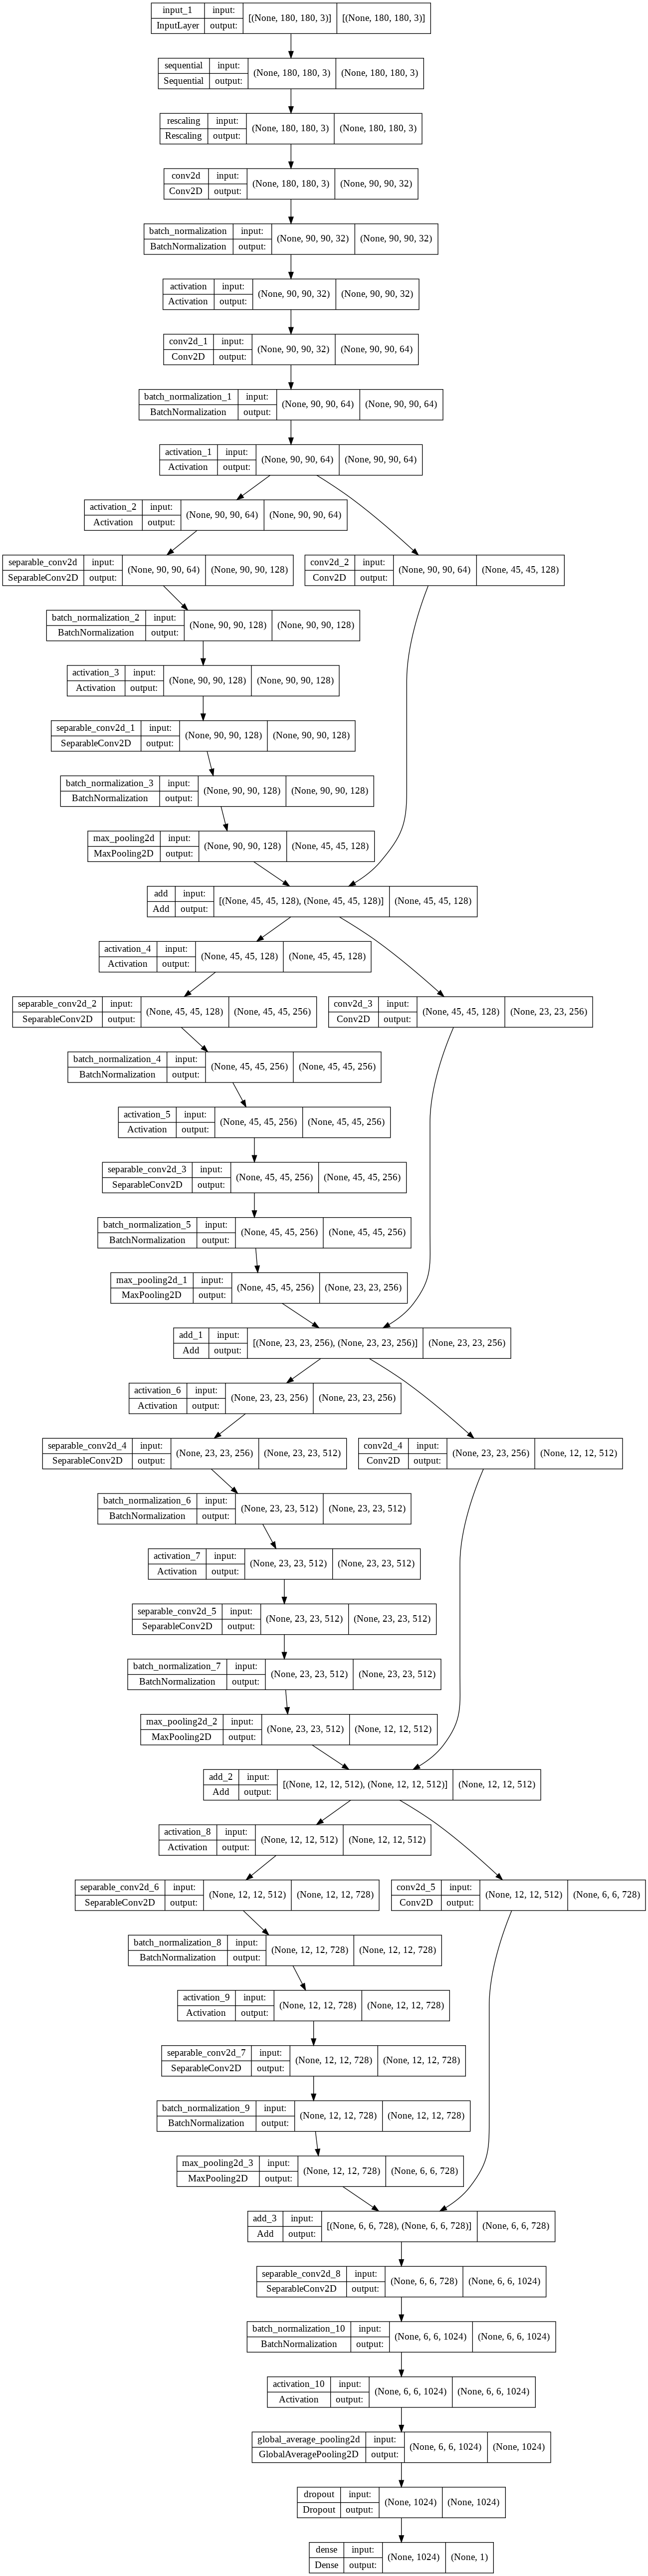

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)



In [14]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 175s 273ms/step - loss: 0.6315 - accuracy: 0.6576 - val_loss: 0.9282 - val_accuracy: 0.5361
Epoch 2/50
586/586 [==============================] - 158s 270ms/step - loss: 0.4638 - accuracy: 0.7834 - val_loss: 0.4386 - val_accuracy: 0.8044
Epoch 3/50
586/586 [==============================] - 159s 271ms/step - loss: 0.3816 - accuracy: 0.8307 - val_loss: 0.3675 - val_accuracy: 0.8454
Epoch 4/50
586/586 [==============================] - 159s 271ms/step - loss: 0.3207 - accuracy: 0.8614 - val_loss: 0.3253 - val_accuracy: 0.8686
Epoch 5/50
586/586 [==============================] - 159s 271ms/step - loss: 0.2709 - accuracy: 0.8856 - val_loss: 0.2319 - val_accuracy: 0.9045
Epoch 6/50
586/586 [==============================] - 158s 270ms/step - loss: 0.2352 - accuracy: 0.8994 - val_loss: 0.3611 - val_accuracy: 0.8558
Epoch 7/50
586/586 [==============================] - 159s 270ms/step - loss: 0.2066 - accuracy: 0.9158 - val_loss: 0.1795 -

In [14]:
#RunTime = 2.20833333333h or 159min